This notebook demonstrates how to use BART for parallel MRI reconstruction. 

To run locally, we'll need:

1. a `bart` installation (v0.7.00 or later) 

2. a `python3` programming environment

3. to expose our `python3` instance to `bart`'s python bindings in `/path/to/bart/python`. 

We can check our environment by importing the necessary libraries:

In [1]:
import bart
import cfl
import matplotlib.pyplot as plt
import numpy as np

The `bart` python module contains an eponymous function that enables calling `bart` functions from a python instance. The syntax is `output = bart.bart(nargout, command, arg0, arg1, ...)`.

As an example, let's simulate some multicoil k-space data with the `phantom` command:

In [2]:
nkyz = 256
nc = 8
ksp_ful_nonoise = bart.bart(1, 'phantom -x {} -s {} -k'.format(nkyz, nc))
ksp_ful_nonoise.shape

(256, 256, 1, 8)

In the sequel, we'll be undersampling with a pattern that is feasible along phase-encoding directions only. For clarity, let's orient our readout direction along the 0th axis and reshape accordingly:

In [3]:
ksp_ful_nonoise.shape = (1, nkyz, nkyz, nc)

Let's also add noise of a given variance level, fixing the random seed for reproducibility:

In [4]:
noi_var = 1000
seed = 20210714
ksp_ful = bart.bart(1, 'noise -n {} -s {}'.format(noi_var, seed), ksp_ful_nonoise)
ksp_ful.shape

(1, 256, 256, 8)

Multicoil acquisitions enable reasonable reconstruction from undersampled data, so let's mask out some entries of our fully-sampled data `ksp_ful` before proceeding. 

We can construct a binary Poisson-disk sampling mask using the `poisson` command. The options `-y` and `-z` enable setting a different undersampling levels along each axis. The option `-C` sets the width and height of a fully-sampled central region. The option `-V` controls how uniformly samples are distributed in the higher-frequency regions of k-space.

In [5]:
usamp_lvl_y = 3
usamp_lvl_z = 1.5
calib_dim = 16
vdf = 20
mask_args = (nkyz, nkyz, usamp_lvl_y, usamp_lvl_z, calib_dim, vdf)
mask = bart.bart(1, 'poisson -Y {} -Z {} -y {} -z {} -C {} -V {} -e'.format(*mask_args))
mask.shape

(1, 256, 256)

Note that the `mask` shape reflects 3D Poisson-disk sampling, as is used in practice. Let's apply the mask and take a look:

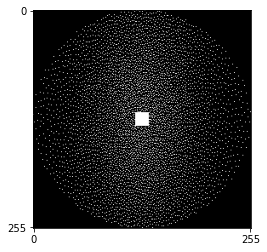

In [6]:
def disp(im, figsize=(4,4)): # to avoid code repetition
    _, ax = plt.subplots(figsize=figsize)
    ax.set_xticks([0, nkyz-1])
    ax.set_yticks([0, nkyz-1])
    ax.imshow(abs(np.squeeze(im)), cmap='gray')
    
mask.shape = (1, nkyz, nkyz, 1) # for array broadcasting
ksp = ksp_ful * mask
disp(mask)

We now have Poisson-disk undersampled multicoil k-space data and will seek to reconstruct this data in a few different ways. 

Let's first try a simple FFT-based reconstruction. The idea is to apply an FFT along the $k_y, k_z$ directions to produce an image for each coil, and then to combine these coil images pixel-by-pixel by calculating the root sum-of-squares across coils. We can implement these steps via the `fft` and `rss` commands, respectively. 

Both `fft` and `rss` use bitmasks to specify the dimensions along which to operate. BART facilitates bitmask calculation using the `bitmask` command. For example, we need to apply `fft` along the 1st and 2nd dimensions of `ksp`. The associated bitmask (in decimal representation) can be calculated as:

In [7]:
!bart bitmask 1 2

6


We pass this decimal bitmask to the `fft` command to produce coil images:

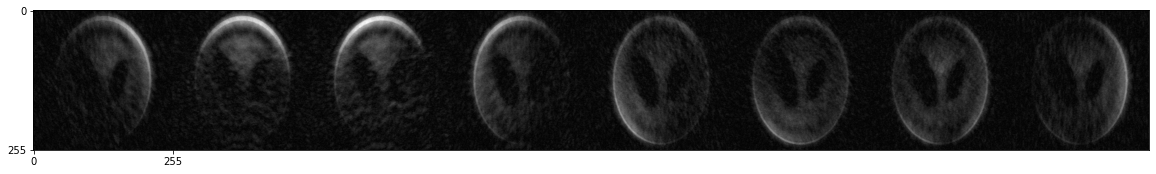

In [8]:
im_coil = bart.bart(1, 'fft -u -i 6', ksp)
disp(np.concatenate([im_coil[0,:,:,i] for i in range(nc)], 1), figsize=(20,10))

We also need to apply `rss` along the 3rd dimension of `im_coil`. We can calculate and then pass the decimal bitmask to `rss` to obtain the FFT-based reconstruction:

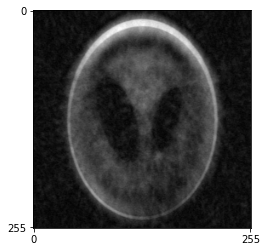

In [9]:
im_rss = bart.bart(1, 'rss $(bart bitmask 3)', im_coil)
disp(im_rss)

As expected, FFT-based reconstruction yields a blurry image. We can improve on this by leveraging redundancy across receiver coils more carefully. One common alternative involves first estimating each coil's spatial sensitivity profile, and then incorporating that additional coil sensitivity information into the reconstruction. BART contains implementations of several algorithms that are consistent with this general approach, and we'll next apply a popular one called ESPIRiT. To learn more about ESPIRiT, check out the original [paper](https://onlinelibrary.wiley.com/doi/10.1002/mrm.24751).

Since coil sensitivities vary slowly in space, it suffices to estimate them from low-frequency k-space data. One could use the fully-sampled center of `ksp`, and BART is compatible with this common approach. We'll instead use a separate low-resolution dataset, which will yield sensitivity maps that are uncorrelated with `ksp`:

In [10]:
ksp_smap_nonoise = bart.bart(1, 'phantom -x {} -k -s {}'.format(calib_dim, nc))
ksp_smap_nonoise.shape = (1, calib_dim, calib_dim, nc)
seed_smap = 14072021
ksp_smap = bart.bart(1, 'noise -n {} -s {}'.format(noi_var, seed_smap), ksp_smap_nonoise)
ksp_smap.shape

(1, 16, 16, 8)

We can estimate ESPIRiT coil sensitivities with the `ecalib` command. This command uses the coil sensitivity data's shape to decide the resolution at which to output coil sensitivities, so we'll need to zero-pad `ksp_smap` before proceeding. BART makes padding easy with the `resize` command: 

In [11]:
ksp_smap_pad = bart.bart(1, 'resize -c 1 {} 2 {}'.format(nkyz, nkyz), ksp_smap)
ksp_smap_pad.shape

(1, 256, 256, 8)

Like most iterative reconstruction algorithms, ESPIRiT can take a long time. We can accelerate computation by compressing the data to a smaller number `nvc` of *virtual* coils prior to reconstruction. 

BART's `cc` command contains implementations of several coil compression algorithms; we'll use the `-S` flag to choose SVD-type compression.  

Physical and virtual coil profiles are often related to each other by a *coil compression matrix*. There are often many equally good virtual coil orientations for any given geometry, so we'll need to make sure that our virtual coil sensitivities and virtual coil data relate to their physical counterparts by the same compression matrix. The `cc` command enables this with the `-M` flag, which causes the compression matrix to be output in lieu of compressed data. Then the same compression matrix can be applied to both `ksp_smap_pad` and `ksp` via the `ccapply` command: 

In [12]:
cc_mtx = bart.bart(1, 'cc -S -M', ksp_smap_pad)
nvc = 5
ksp_smap_cc = bart.bart(1, 'ccapply -p {} -S'.format(nvc), ksp_smap_pad, cc_mtx)
ksp_smap_cc.shape

(1, 256, 256, 5)

In [13]:
ksp_cc = bart.bart(1, 'ccapply -p {} -S'.format(nvc), ksp, cc_mtx)
ksp_cc.shape

(1, 256, 256, 5)

Let's now estimate ESPIRiT virtual coil sensitivities with the `ecalib` command. We'll use the `-m 1` option to compute only the first set of sensitivity maps:

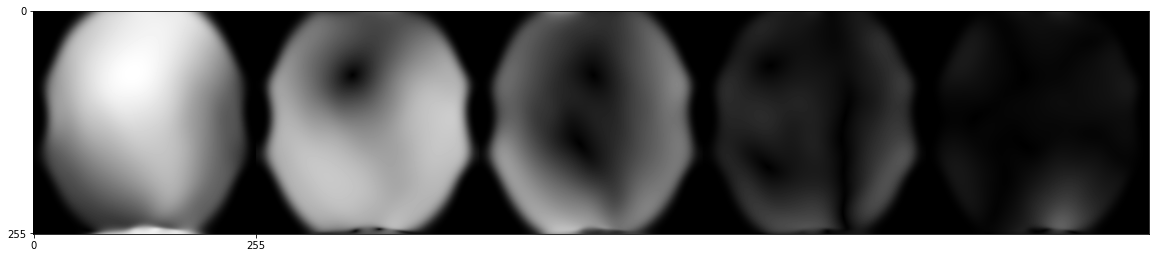

In [14]:
smap = bart.bart(1, 'ecalib -m 1 -S', ksp_smap_cc)
disp(np.concatenate([smap[0,:,:,i] for i in range(nvc)], 1), figsize=(20,10))

We're finally ready for iterative reconstruction. BART's `pics` command enables ESPIRiT reconstruction with one or more regularization terms, each specified with an `-R <T>:A:B:C` option. Here, 

-- `<T>` denotes regularization type,

-- `A` is a bitmask that denotes the dimensions along which to apply a transform (if needed),

-- `B` is a bitmask that denotes the dimensions along which to jointly regularize (if needed),

-- `C` is the regularization strength.  

We'll also use the `-S` flag to rescale images before output, for comparison purposes.

First, let's run `pics` using $\ell_2$-norm regularization in the image domain:

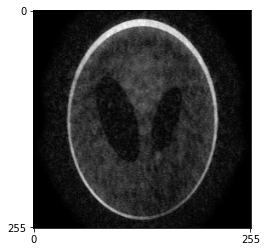

In [15]:
l2_reg = 0.1
im_l2 = bart.bart(1, 'pics -R Q:{} -S -d5'.format(l2_reg), ksp_cc, smap)
disp(im_l2)

Second, let's run `pics` using $\ell_1$-norm regularization in a wavelet domain, where the wavelet transform is applied along the spatial (i.e., 1st, 2nd) dimensions:

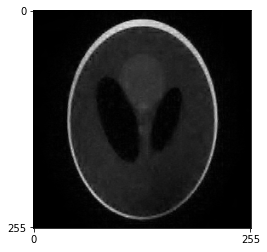

In [16]:
l1wav_reg = 0.1
im_wav = bart.bart(1, 'pics -R W:$(bart bitmask 1 2):0:{} -S -d5'.format(l1wav_reg), 
                   ksp_cc, smap)
disp(im_wav)

Third, let's run `pics` using $\ell_1$-norm regularization on image finite differences, where the differences are taken along both spatial dimensions (i.e., total variation):

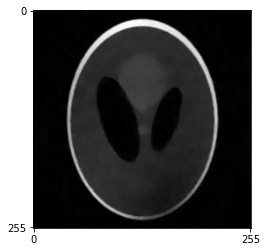

In [17]:
l1tv_reg = 0.1
im_tv = bart.bart(1, 'pics -R T:$(bart bitmask 1 2):0:{} -S -d5'.format(l1tv_reg), 
                  ksp_cc, smap)
disp(im_tv)

Finally, let's take a look at our various reconstructions side-by-side. As a reference, we'll also evaluate and display a root-sum-of-squares reconstruction using the fully-sampled noiseless data.

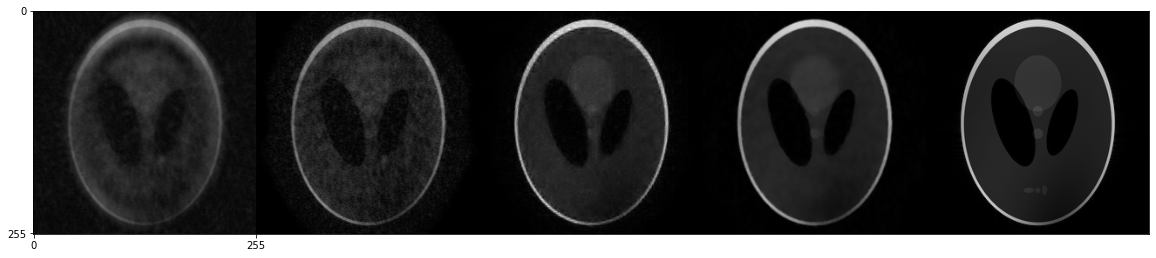

In [18]:
# root-sum-of-squares reconstruction from fully-sampled data
im_coil_full = bart.bart(1, 'fft -i -u $(bart bitmask 1 2)', ksp_ful_nonoise)
im_rss_full = bart.bart(1, 'rss $(bart bitmask 3)', im_coil_full)
disp(np.concatenate([im_rss, im_l2, im_wav, im_tv, im_rss_full], 2), figsize=(20,10))